In [4]:
#CREO UNA MATRICE DOVE HO FILM E COME ATTRIBUTI I SUOI TAGS, raccomando in base ai tags

import os
import scipy.sparse as sps
import numpy as np
import scipy.sparse as sps

def rowSplit (rowString):
    
    split = rowString.split(",")#occhio che .csv splitta con virgola prof con ::
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])#userID
    split[1] = int(split[1])#filmID
    split[2] = float(split[2])#rating
    split[3] = int(split[3])#timestamp
    
    result = tuple(split)
    return result

URM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_SYSTEMS\movies100krates\ratings.csv", 'r')
URM_file.seek(0)
URM_tuples = []
numberInteractions=0
#ho 100836 voti di  610 utenti su 9724 diversi filmz
URM_file.readline()

#for _ in 10:   #rende esecuzione + easy se necessario con solo 10 ratings
#   URM_file.readline()   
#   numberInteractions+=1
for line in URM_file:
    URM_tuples.append(rowSplit (line))
    numberInteractions+=1
#print(len(URM_tuples))
userList, itemList, ratingList, timestampList = zip(*URM_tuples)
userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)



URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

print("Num utenti: ",len(set(userList)))
print("Num filmz: ",len(set(itemList)))
print("Num voti: ",len(ratingList))




Num utenti:  610
Num filmz:  9724
Num voti:  100836


In [21]:
#Carico la mia ICM x=item y=attributo

def rowSplit (rowString):
    
    split = rowString.split(",")#occhio che .csv splitta con virgola prof con ::
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])#userID
    split[1] = int(split[1])#filmID
    split[2] = str(split[2])#tag, sono i nostri attributi
    split[3] = int(split[3])#timestamp
    
    result = tuple(split)
    return result

ICM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_SYSTEMS\movies100krates\tags.csv", 'r')
ICM_file.seek(0)
ICM_tuples = []
numberInteractions=0
ICM_file.readline()
for line in ICM_file:
    ICM_tuples.append(rowSplit (line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)
userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)
print("Num utenti: ",len(set(userList_icm)))#I diversi utenti film e tags
print("Num filmz: ",len(set(itemList_icm)))
print("Num tags : ",len(set(tagList_icm)), "Occhio che ce ne sono di uguali, in tot. sono: ",len(tagList_icm))
tagsBackup=deepcopy(tagList_icm)

Num utenti:  58
Num filmz:  1572
Num tags :  1589 Occhio che ce ne sono di uguali, in tot. sono:  3683


In [25]:
#trasforma tags in numeri per usarli come indici
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)
print("Tags prima e dopo:")
print(tagsBackup[0:5])
print(tagList_icm[0:5])

import numpy as np

n_items = URM_all.shape[1]
n_tags = max(tagList_icm) + 1

ICM_shape = (n_items, n_tags)

ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape = ICM_shape)
ICM_all = ICM_all.tocsr()

ICM_all

Tags prima e dopo:
['funny', 'Highly quotable', 'will ferrell', 'Boxing story', 'MMA']
[ 936  231 1573   73  322]


<193610x1589 sparse matrix of type '<class 'numpy.float64'>'
	with 3579 stored elements in Compressed Sparse Row format>

(193610,)
(1589,)
Vedo che quasi tutte le items hanno 0 tags, una 175 e in generale pochi film ne hanno


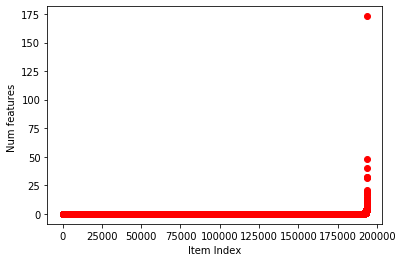

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
#vediamo come sono distribuiti item e tags
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)
ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)
ICM_all = sps.csr_matrix(ICM_all)

print(features_per_item.shape)
print(items_per_feature.shape)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)
import matplotlib.pyplot as pyplot
%matplotlib inline  

print("Vedo che quasi tutte le items hanno 0 tags, una 175 e in generale pochi film ne hanno")
pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()
# se faccio così infatti vedrò che è tipo tutto 0
#print(ICM_all.todense())

# Ora raccomando:


In [49]:
from Notebooks_utils.data_splitter import train_test_holdout
from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)

class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
    #topK=num nearest neighbours
    #shrinkage= num samples uso x supp similarity (support)
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
         #calcola similarity per ogni USER (self)
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink,
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        self.W_sparse = similarity_object.compute_similarity()
    
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product e ritorna items con più similarity, in ordine
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]   
        return ranking[:at]
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [50]:
#fit
#recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
#recommender.fit(shrink=0.0, topK=50)

print("Vedo che i tempi sono enormi!!! allora commento o non potrei fare nulla ahah")

#raccomanda
#userList_unique = list(set(userList_icm))
#for user_id in userList_unique[0:10]
    #print(recommender.recommend(user_id, at=5))



Vedo che i tempi sono enormi!!! allora commento o non potrei fare nulla ahah


In [52]:
#occhio ai tempi abnormi!!
x_tick = [10, 50, 100, 350]
MAP_per_k = []
print("Cambia num of neighbours che è TOPK")
for topK in x_tick:
    
    recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])
    
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Cambia num of neighbours che è TOPK
Similarity column 10100 (  5 % ), 335.73 column/sec, elapsed time 0.50 min
Similarity column 20300 ( 10 % ), 336.62 column/sec, elapsed time 1.01 min
Similarity column 30400 ( 16 % ), 335.63 column/sec, elapsed time 1.51 min
Similarity column 40300 ( 21 % ), 333.71 column/sec, elapsed time 2.01 min
Similarity column 50500 ( 26 % ), 334.67 column/sec, elapsed time 2.51 min
Similarity column 60500 ( 31 % ), 334.31 column/sec, elapsed time 3.02 min
Similarity column 69900 ( 36 % ), 330.92 column/sec, elapsed time 3.52 min
Similarity column 79100 ( 41 % ), 327.83 column/sec, elapsed time 4.02 min
Similarity column 89100 ( 46 % ), 328.34 column/sec, elapsed time 4.52 min


KeyboardInterrupt: 